Download the `sentimen140` dataset from Kaggle.

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! kaggle datasets download kazanova/sentiment140

 99% 80.0M/80.9M [00:02<00:00, 44.1MB/s]
100% 80.9M/80.9M [00:02<00:00, 33.9MB/s]


In [ ]:
! unzip /content/sentiment140.zip

Archive:  /content/sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


Import required dependencies.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.initializers import glorot_uniform
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

Load the dataset into pandas dataframe. 

Out of 1.6 million tweets, we just took 40,000 tweets (20,000 from each classes).

In [ ]:
train_df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=['label', 'ID', 'Date_Time','NO_QUERY','Account_Name','tweet'])
df1 = train_df.head(20000)
df2 = train_df.tail(20000)
frames = [df1, df2]
train_df = pd.concat(frames)
train_df = train_df.replace({'label':4},1)
train_df

,label,ID,Date_Time,NO_QUERY,Account_Name,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
train_df['label'].value_counts()

0    20000
1    20000
Name: label, dtype: int64

## Data Preprocessing

Now our dataset contains words and ML model dosen't understand the language of words. So we have to convert our dataset from words to numbers. To do this, we have used `Word Lemmatization` method.

In [ ]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

--2022-12-20 10:50:18--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.39MB/s    in 2m 41s  

2022-12-20 10:52:59 (5.10 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
words = dict()

def add_to_dict(d, filename):
  with open(filename, 'r') as f:
    for line in f.readlines():
      line = line.split(' ')

      try:
        d[line[0]] = np.array(line[1:], dtype=float)
      except:
        continue

add_to_dict(words, 'glove.6B.50d.txt')

In [ ]:
len(words)

400000

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In the below two cells, I have deal with unwanted text, emojies, urls and many more. 

In [ ]:
# Define the dictionary to replace emojis with words
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [ ]:
# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern       = '@[^\s]+'
alphaPattern      = "[^a-zA-Z0-9]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

def preprocess(tweet):
  tweet = tweet.lower()

  # Replace all URls with 'URL'
  tweet = re.sub(urlPattern,'',tweet)
  # Replace all emojis.
  for emoji in emojis.keys():
      tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
  # Replace @USERNAME to 'USER'.
  tweet = re.sub(userPattern,'user', tweet)        
  # Replace all non alphabets.
  tweet = re.sub(alphaPattern, " ", tweet)
  # Replace 3 or more consecutive letters by 2 letter.
  tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
  return tweet

for i in train_df['tweet']:
  tweet = preprocess(i)
  train_df = train_df.replace(i,tweet)

train_df['tweet']

0          user  aww  that s a bummer  you shoulda got da...
1          is upset that he can t update his facebook by ...
2          user i dived many times for the ball  managed ...
3            my whole body feels itchy and like its on fire 
4          user no  it s not behaving at all  i m mad  wh...
                                 ...                        
1599995    just woke up  having no school is the best fee...
1599996    thewdb com  very cool to hear old walt intervi...
1599997    are you ready for your mojo makeover  ask me f...
1599998    happy 38th birthday to my boo of all time  tup...
1599999                happy  charitytuesday user user user 
Name: tweet, Length: 40000, dtype: object

Used tokenizer from nltk to split a complete sentence in a token of words.

In [ ]:
tokenizer = nltk.RegexpTokenizer(r"\w+")

tokenizer.tokenize('@user when a father is dysfunctional and is')

['user', 'when', 'a', 'father', 'is', 'dysfunctional', 'and', 'is']

In the below cell, I have used `WordNetLemmatizer` to convert text into numbers.

In [ ]:
lemmatizer = WordNetLemmatizer()

lemmatizer.lemmatize('feet')

def message_to_token_list(s):
  tokens = tokenizer.tokenize(s)
  lowercased_tokens = [t.lower() for t in tokens]
  lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens]
  useful_tokens = [t for t in lemmatized_tokens if t in words]

  return useful_tokens

message_to_token_list('@user feet a fathers is dysfunctional and is')

['user', 'foot', 'a', 'father', 'is', 'dysfunctional', 'and', 'is']

In [ ]:
def message_to_word_vectors(message, word_dict=words):
  processed_list_of_tokens = message_to_token_list(message)

  vectors = []

  for token in processed_list_of_tokens:
    if token not in word_dict:
      continue
    
    token_vector = word_dict[token]
    vectors.append(token_vector)
  
  return np.array(vectors, dtype=float)

In [ ]:
message_to_word_vectors('@user when a father is dysfunctional and is').shape

(8, 50)

Creat `Train`, `Validation` and `Test` splits.

In [ ]:
train_df = train_df.sample(frac=1, random_state=1)
train_df.reset_index(drop=True, inplace=True)

split_index_1 = int(len(train_df) * 0.9)
split_index_2 = int(len(train_df) * 0.7)

train_df, test_df = train_df[:split_index_1], train_df[split_index_1:]
train_df, val_df = train_df[:split_index_2], train_df[split_index_2:]

len(train_df), len(val_df), len(test_df)

(28000, 8000, 4000)

In [ ]:
def df_to_X_y(dff):
  y = dff['label'].to_numpy().astype(int)

  all_word_vector_sequences = []

  for message in dff['tweet']:
    message_as_vector_seq = message_to_word_vectors(message)
    
    if message_as_vector_seq.shape[0] == 0:
      message_as_vector_seq = np.zeros(shape=(1, 50))

    all_word_vector_sequences.append(message_as_vector_seq)
  
  return all_word_vector_sequences, y

In [ ]:
X_train, y_train = df_to_X_y(train_df)

print(len(X_train), len(X_train[0]))

28000 3


In [ ]:
print(len(X_train), len(X_train[2]))

28000 16


(array([4.196e+03, 7.443e+03, 5.084e+03, 5.013e+03, 3.169e+03, 2.647e+03,
        4.370e+02, 8.000e+00, 2.000e+00, 1.000e+00]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <a list of 10 Patch objects>)

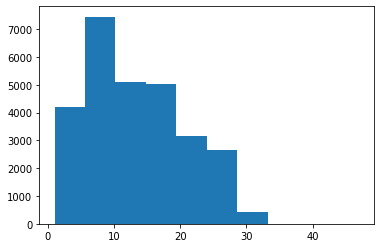

In [ ]:
sequence_lengths = []

for i in range(len(X_train)):
  sequence_lengths.append(len(X_train[i]))

import matplotlib.pyplot as plt

plt.hist(sequence_lengths)

In [ ]:
pd.Series(sequence_lengths).describe()

count    28000.000000
mean        13.290286
std          7.201816
min          1.000000
25%          7.000000
50%         12.000000
75%         19.000000
max         47.000000
dtype: float64

In [ ]:
from copy import deepcopy

def pad_X(X, desired_sequence_length):
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_difference = desired_sequence_length - x_seq_len
    
    pad = np.zeros(shape=(sequence_length_difference, 50))

    X_copy[i] = np.concatenate([x, pad])
  
  return np.array(X_copy).astype(float)

In [ ]:
X_train = pad_X(X_train, 80)

X_train.shape

(28000, 80, 50)

In [ ]:
y_train.shape

(28000,)

In [ ]:
X_val, y_val = df_to_X_y(val_df)
X_val = pad_X(X_val, 80)

X_val.shape, y_val.shape

((8000, 80, 50), (8000,))

In [ ]:
X_test, y_test = df_to_X_y(test_df)
X_test = pad_X(X_test, 80)

X_test.shape, y_test.shape

((4000, 80, 50), (4000,))

## Federated Learning Algorithm

For the federated learning mechanism, we need client devices so that we can test our model. Here by splitting the training dataframe I have created dummy clients to test ML model.

In [ ]:
def create_clients(X_train, y_train, num):
    X_train = np.array_split(X_train, num)
    y_train = np.array_split(y_train, num)
    return X_train, y_train

X_train_federated, y_train_federated = create_clients(X_train, y_train, 5)

Define basic `LSTM` neural network using `TensorFLow` framework.

In [ ]:
class NN:
    @staticmethod
    def build():
        model = Sequential()
        model.add(layers.Input(shape=(80, 50)))
        model.add(layers.LSTM(64, return_sequences=True))
        model.add(layers.Dropout(0.2))
        model.add(layers.LSTM(64, return_sequences=True))
        model.add(layers.Dropout(0.2))
        model.add(layers.LSTM(64, return_sequences=True))
        model.add(layers.Dropout(0.2))
        model.add(layers.Flatten())
        model.add(layers.Dense(1, activation='sigmoid'))
        return model

In [ ]:
frequencies = pd.value_counts(train_df['label'])

frequencies

0    14075
1    13925
Name: label, dtype: int64

Define `test` function.

In [ ]:
cla_report = []
fed_val_losses = []

def mean_weights(weight_list): 
    return np.mean(weight_list, axis=0)

def test_model(X_test, y_test,  model, comms_round):
    logits = (model.predict(X_test) > 0.5).astype(int)
    report = classification_report(y_test, logits, output_dict=True)
    cla_report.append(report)
    print(f'COMMUNICATION ROUND : {comms_round+1}')
    print(classification_report(y_test, logits))
    fed_val_losses.append(log_loss(y_test,logits))

Define complete training cycle.

In [ ]:
data = list(zip(X_train_federated, y_train_federated))
comms_round = 20

smlp_global = NN()
global_model = smlp_global.build()

for comm_round in range(comms_round):
    global_weights = global_model.get_weights()
    local_weight_list = list()
    for i in data:
        smlp_local = NN()
        local_model = smlp_local.build()
        local_model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=0.0001),metrics=['accuracy', AUC(name='auc')])
        local_model.set_weights(global_weights)
        local_model.fit(i[0], i[1], epochs=5, verbose=0)
        local_weight_list.append(np.array(local_model.get_weights(), dtype=object))
        K.clear_session()
    average_weights = mean_weights(local_weight_list)
    global_model.set_weights(average_weights)
    
    test_model(X_val, y_val, global_model, comm_round)

250/250 [==============================] - 13s 43ms/step
COMMUNICATION ROUND : 1
              precision    recall  f1-score   support

           0       0.65      0.74      0.69      3956
           1       0.71      0.61      0.65      4044

    accuracy                           0.68      8000
   macro avg       0.68      0.68      0.67      8000
weighted avg       0.68      0.68      0.67      8000

250/250 [==============================] - 10s 40ms/step
COMMUNICATION ROUND : 2
              precision    recall  f1-score   support

           0       0.68      0.71      0.69      3956
           1       0.70      0.67      0.69      4044

    accuracy                           0.69      8000
   macro avg       0.69      0.69      0.69      8000
weighted avg       0.69      0.69      0.69      8000

250/250 [==============================] - 11s 41ms/step
COMMUNICATION ROUND : 3
              precision    recall  f1-score   support

           0       0.66      0.77      0.71     

Predictions on `test` dataset.

In [ ]:
federated_preds = (global_model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, federated_preds))

125/125 [==============================] - 5s 41ms/step
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      1969
           1       0.75      0.71      0.73      2031

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000



In [ ]:
log_loss(y_test,federated_preds)

9.118330721055111

Confusion matrix and graphs.

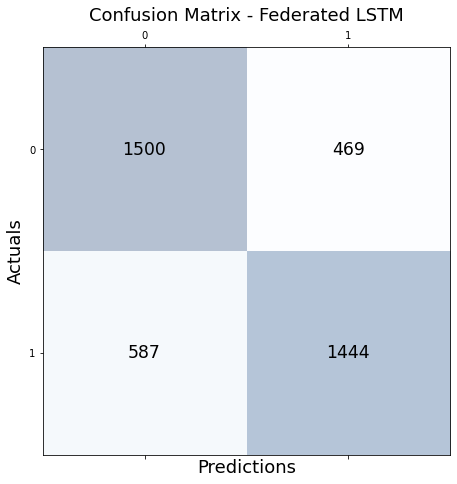

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, federated_preds)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix - Federated LSTM', fontsize=18)
plt.show()

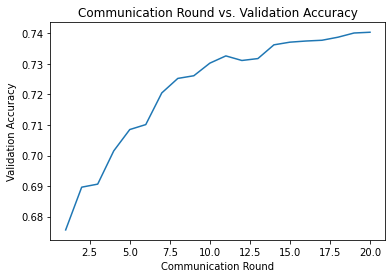

In [ ]:
x = []
for i in range(comms_round):
  x.append(i+1)
y = []
for i in range(comms_round):
  acc = cla_report[i]['accuracy']
  y.append(acc)
plt.plot(x,y)
plt.title("Communication Round vs. Validation Accuracy")
plt.xlabel('Communication Round')
plt.ylabel('Validation Accuracy')
plt.show()

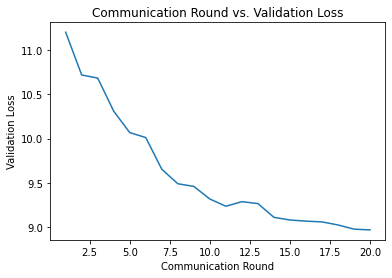

In [ ]:
x = []
for i in range(comms_round):
  x.append(i+1)
plt.plot(x,fed_val_losses)
plt.title("Communication Round vs. Validation Loss")
plt.xlabel('Communication Round')
plt.ylabel('Validation Loss')
plt.show()

## Server Based Learning (Normal)

In [ ]:
lstm = NN().build()
lstm.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=0.0001),metrics=['accuracy', AUC(name='auc')])
hist = lstm.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
875/875 [==============================] - 125s 138ms/step - loss: 0.6243 - accuracy: 0.6477 - auc: 0.7060 - val_loss: 0.5915 - val_accuracy: 0.6854 - val_auc: 0.7550
Epoch 2/10
875/875 [==============================] - 118s 135ms/step - loss: 0.5811 - accuracy: 0.6915 - auc: 0.7606 - val_loss: 0.5868 - val_accuracy: 0.6862 - val_auc: 0.7634
Epoch 3/10
875/875 [==============================] - 120s 137ms/step - loss: 0.5710 - accuracy: 0.7000 - auc: 0.7711 - val_loss: 0.5918 - val_accuracy: 0.6820 - val_auc: 0.7715
Epoch 4/10
875/875 [==============================] - 119s 136ms/step - loss: 0.5629 - accuracy: 0.7067 - auc: 0.7796 - val_loss: 0.5735 - val_accuracy: 0.6966 - val_auc: 0.7792
Epoch 5/10
875/875 [==============================] - 120s 137ms/step - loss: 0.5548 - accuracy: 0.7130 - auc: 0.7873 - val_loss: 0.5571 - val_accuracy: 0.7121 - val_auc: 0.7865
Epoch 6/10
875/875 [==============================] - 122s 140ms/step - loss: 0.5459 - accuracy: 0.7201 - auc:

In [ ]:
preds = (lstm.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, preds))

125/125 [==============================] - 6s 41ms/step
              precision    recall  f1-score   support

           0       0.76      0.63      0.69      1969
           1       0.69      0.81      0.75      2031

    accuracy                           0.72      4000
   macro avg       0.73      0.72      0.72      4000
weighted avg       0.73      0.72      0.72      4000



In [ ]:
from sklearn.metrics import log_loss
log_loss(y_test,preds)

9.653732529613045

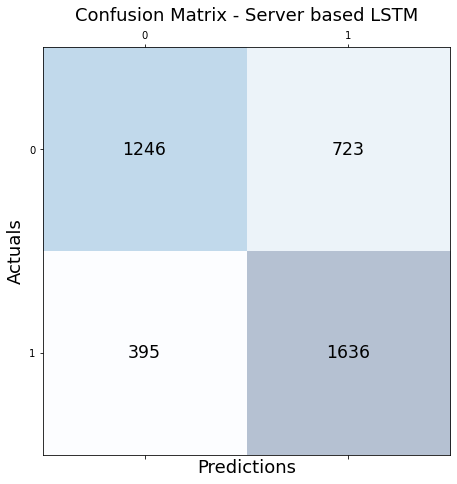

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, preds)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix - Server based LSTM', fontsize=18)
plt.show()

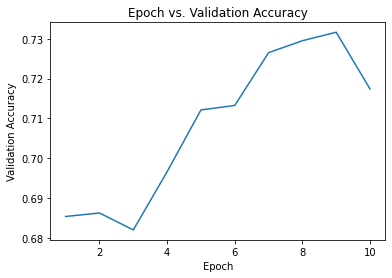

In [ ]:
x = []
for i in range(10):
  x.append(i+1)
y = hist.history['val_accuracy']
plt.plot(x,y)
plt.title("Epoch vs. Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()

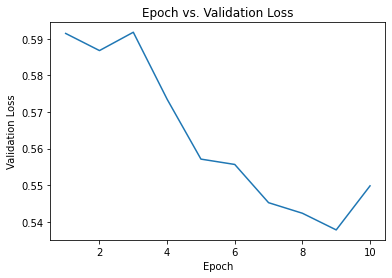

In [ ]:
x = []
for i in range(10):
  x.append(i+1)
y = hist.history['val_loss']
plt.plot(x,y)
plt.title("Epoch vs. Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

## Sanders – Twitter Sentiment Corpus Dataset

In [ ]:
import requests

url = 'https://raw.githubusercontent.com/zfz/twitter_corpus/master/full-corpus.csv'
res = requests.get(url, allow_redirects=True)
with open('Tweet_dataset.csv','wb') as file:
    file.write(res.content)
df_3 = pd.read_csv('Tweet_dataset.csv', names=['topic','label','id','date','tweet'])
df_3 = df_3.drop(index=0)
df_3 = df_3.loc[(df_3['label'] == 'positive') | (df_3['label'] == 'negative')]
df_3 = df_3.replace({'label': {'positive': 1, 'negative': 0}})

In [ ]:
for i in df_3['tweet']:
  tweet = preprocess(i)
  df_3 = df_3.replace(i,tweet)

In [ ]:
# neg_df = df_3[df_3['label'] == 0]
# neg_tweets = []
# for i in neg_df['tweet']:
#   neg_tweets.append(i)

# pos_df = df_3[df_3['label'] == 1]
# pos_tweets = []
# for i in pos_df['tweet']:
#   pos_tweets.append(i)

In [ ]:
# Display words which belongs to label '0'

# data_neg = neg_tweets
# plt.figure(figsize = (15,15))
# wc = WordCloud(max_words = 1500 , width = 1600 , height = 800,
#                collocations=False).generate(" ".join(data_neg))
# plt.title('(a) World cloud for negative tweets')
# plt.imshow(wc)

In [ ]:
# Display words which belongs to label '1'

# data_neg = pos_tweets
# plt.figure(figsize = (15,15))
# wc = WordCloud(max_words = 1500 , width = 1600 , height = 800,
#                collocations=False).generate(" ".join(data_neg))
# plt.title('(b) World cloud for positive tweets')
# plt.imshow(wc)

In [ ]:
df_3 = df_3.sample(frac=1, random_state=1)
X_test_3, y_test_3 = df_to_X_y(df_3)

In [ ]:
X_test_3 = pad_X(X_test_3, 80)
X_test_3.shape, y_test_3.shape

((1091, 80, 50), (1091,))

In [ ]:
federated_preds_3 = (global_model.predict(X_test_3) > 0.5).astype(int)
print(classification_report(y_test_3, federated_preds_3))

35/35 [==============================] - 3s 41ms/step
              precision    recall  f1-score   support

           0       0.80      0.54      0.64       572
           1       0.63      0.86      0.72       519

    accuracy                           0.69      1091
   macro avg       0.71      0.70      0.68      1091
weighted avg       0.72      0.69      0.68      1091



In [ ]:
from sklearn.metrics import log_loss
log_loss(y_test_3,federated_preds_3)

10.763882555076659

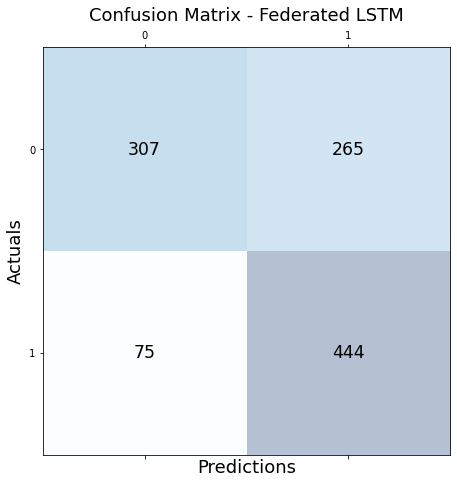

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_3, federated_preds_3)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix - Federated LSTM', fontsize=18)
plt.show()

In [ ]:
preds_3 = (lstm.predict(X_test_3) > 0.5).astype(int)
print(classification_report(y_test_3, preds_3))

35/35 [==============================] - 3s 42ms/step
              precision    recall  f1-score   support

           0       0.78      0.34      0.48       572
           1       0.55      0.89      0.68       519

    accuracy                           0.60      1091
   macro avg       0.67      0.62      0.58      1091
weighted avg       0.67      0.60      0.58      1091



In [ ]:
from sklearn.metrics import log_loss
log_loss(y_test_3,preds_3)

13.64483269958096

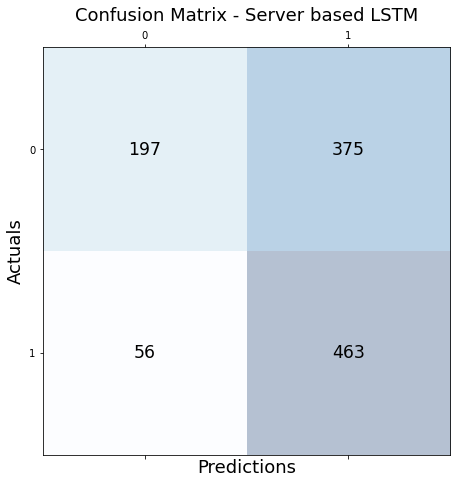

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_3, preds_3)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix - Server based LSTM', fontsize=18)
plt.show()